In [ ]:
import jax.numpy as np
from sklearn.datasets import make_blobs
from jax import random
from jax.flatten_util import ravel_pytree
import matplotlib.pyplot as plt

# Import the core functions from our library
from tsne_jax import *
from utils import *

/ceph/ibmi/it/users/zabel/tsne/dissertation/utils.py:124: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_title('Hessian $\partial_Y^2 f(X, Y^*(X))$')
/ceph/ibmi/it/users/zabel/tsne/dissertation/utils.py:128: SyntaxWarning: invalid escape sequence '\p'
  ax2.set_title('Hessian $\partial_Y^2 f(X, Y^*(X))$ - diag')
/ceph/ibmi/it/users/zabel/tsne/dissertation/utils.py:144: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_title('Eigenvectors Hessian $\partial_Y^2 f(X, Y^*(X))$')
/ceph/ibmi/it/users/zabel/tsne/dissertation/utils.py:152: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_title('Jacobian $\partial_Y \partial_X f(X, Y^*(X))}$')
/ceph/ibmi/it/users/zabel/tsne/dissertation/utils.py:160: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_title('Jacobian $\partial Y^*(X)$')


In [2]:
# 1. Generate sample data and a standard t-SNE embedding
X, labels = make_blobs(n_samples=50, n_features=10, cluster_std=3.0, centers=3, random_state=42)

# Generate random initialization for t-SNE
key = random.PRNGKey(42)
y_guess = random.normal(key, shape=(X.shape[0], 2))

# Use openTSNE to get a high-quality initial embedding
Y = tsne_fwd(X, y_guess)

===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.07 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=4.17 for 250 iterations...
Iteration   50, KL divergence 0.4576, 50 iterations in 0.2662 sec
Iteration  100, KL divergence 0.4576, 50 iterations in 0.2485 sec
Iteration  150, KL divergence 0.4576, 50 iterations in 0.2486 sec
Iteration  200, KL divergence 0.4576, 50 iterations in 0.2477 sec
Iteration  250, KL divergence 0.4576, 50 iterations in 0.2496 sec
   --> Time elapsed: 1.26 seconds
===> Running optimization with exaggeration=1.00, lr=50.00 for 750 iterations...
Iteration   50, KL divergence 0.0216, 50 iterations in 0.2458 sec
Iteration  100, KL divergence 0.0213, 50 iterations in 0.2484 sec
Iteration  150, KL divergence 0.0213, 50 iterations in 0.2485 sec
Iteration  200, KL divergence 0.0213, 50 iterations in 0.2491 sec
Iteration  25

In [3]:
# 2. Prepare data for our JAX functions
# The functions operate on flattened arrays for compatibility with JAX's derivatives
X_flat, X_unflattener = ravel_pytree(X)
Y_flat, Y_unflattener = ravel_pytree(Y)

# Define an example input covariance (e.g., identity matrix)
# This assumes independent and equal variance for all input features
input_cov = np.identity(X_flat.shape[0])
print(input_cov.shape)


(500, 500)


In [4]:
# 3. Compute sensitivities (the Jacobian dY/dX)
# This may take a few minutes depending on your hardware and data size
sensitivities = compute_sensitivities(X_flat, Y_flat, X_unflattener, Y_unflattener, perplexity=30.0)
print(f"Sensitivity matrix (dY/dX) shape: {sensitivities.shape}")

Sensitivity matrix (dY/dX) shape: (100, 500)


In [5]:
# 4. Compute output covariance
# This propagates the input_cov through the learned t-SNE manifold
output_covariance = compute_cov_without_kronecker(X_flat, Y_flat, X_unflattener, Y_unflattener, input_cov, 30.0)
print(f"Output covariance matrix shape: {output_covariance.shape}")

Output covariance matrix shape: (100, 100)


### 5. Visualize the results

<Axes: >

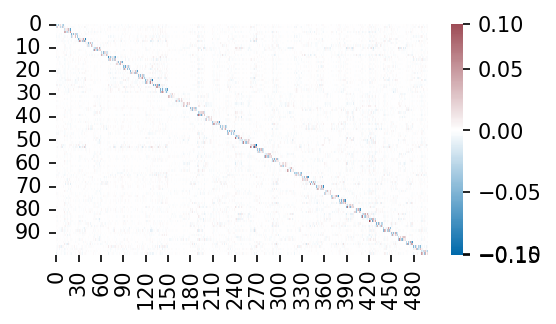

In [6]:
# Sensitivities as a heatmap
plot_heatmap(sensitivities, figsize=(4, 2), with_cell_lines=False)

<Axes: >

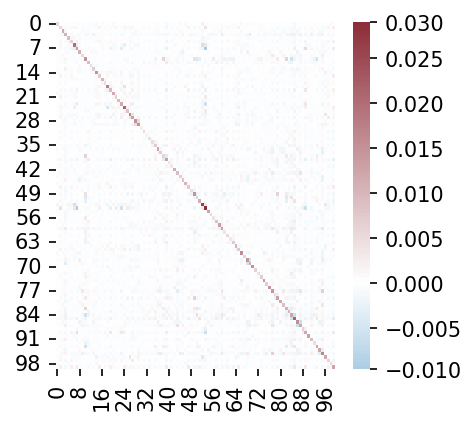

In [7]:
# Output covariance as a heatmap
plot_heatmap(output_covariance, figsize=(3, 3), with_cell_lines=False)

In [8]:
# Generate hypothetical outcomes from the Gaussian distribution N(Y, output_covariance).
# These samples are drawn to follow an orbit of equipotential samples to ensure a smooth visualization
n_samples = 20
S = equipotential_standard_normal(2 * Y.shape[0], n_samples)
L, lower = jax.scipy.linalg.cho_factor(output_covariance+1e-3*np.eye(len(output_covariance)), lower=True)
samples = np.transpose(np.transpose(np.dot(L, S))+Y_flat)

Text(0, 0.5, 'TSNE 2')

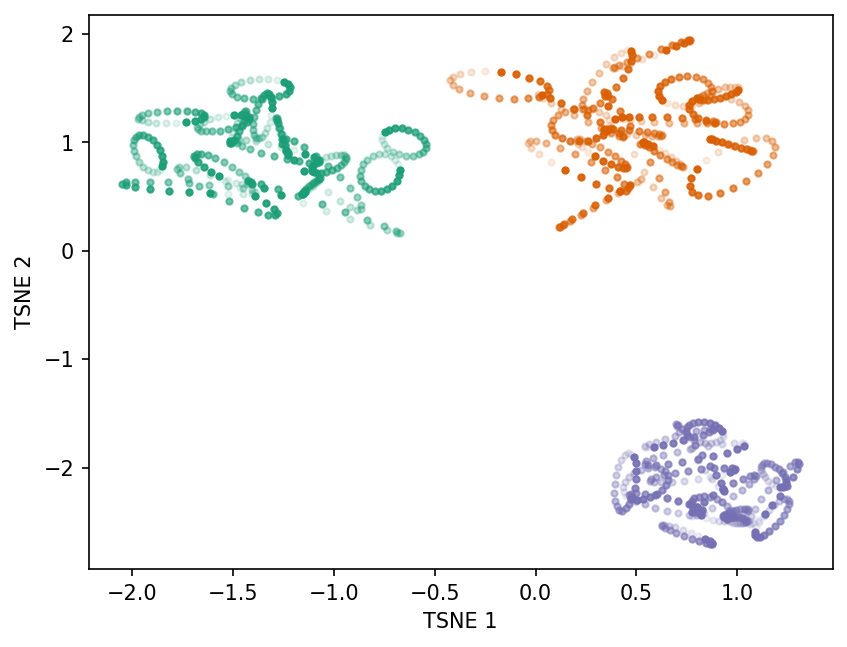

In [9]:
# Visualize samples as traces
colormap = plt.cm.Dark2

fig = plt.figure(1)
for j, sample in enumerate(samples.T):
    sample = Y_unflattener(sample)
    for i, s in enumerate(sample): 
        plt.plot(s[0], s[1], color=colormap.colors[labels[i]], alpha=[i for i in np.arange(0.1, 1, 1/(n_samples+2))][j], marker='.')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')

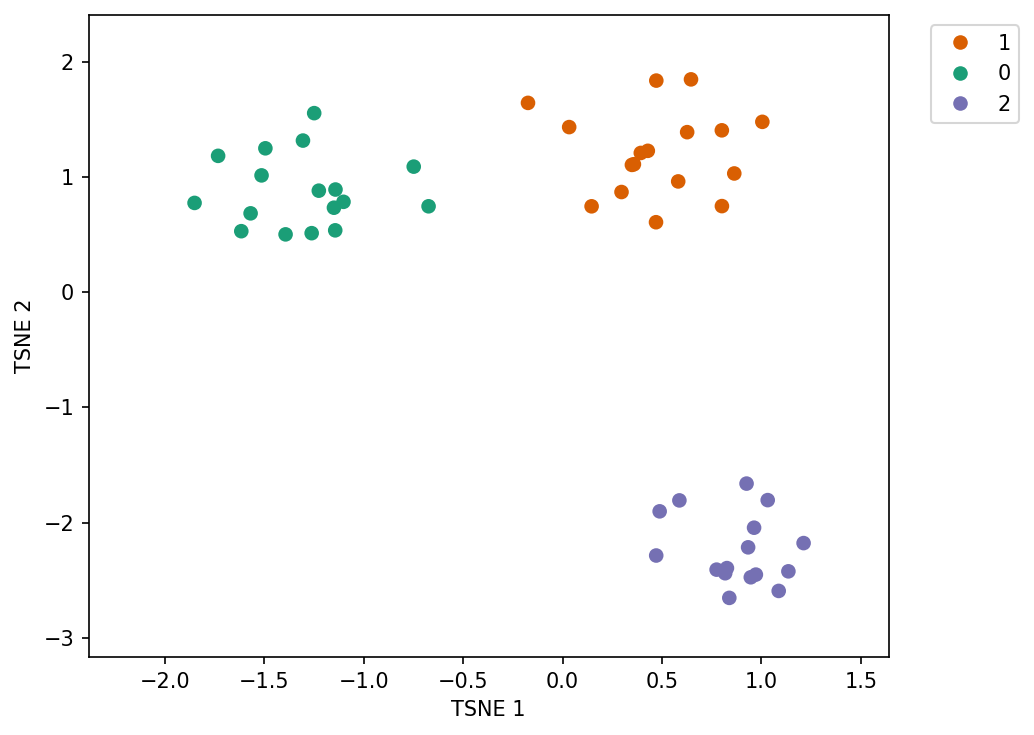

In [10]:
# Visualize samples as an animation
animate(samples, labels, 'example_animation.gif', cmap=colormap.colors)

In [11]:
colormap.colors

((0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4))